In [8]:
from __future__ import print_function
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


#MOST PROBABLY NEED TO NORMALIZE DATA, FOR GAN TO GIVE PROPER OUTPUT

In [9]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import skimage.transform as skt

path = "../AML_Assignment2/cifar/"

def extractImagesAndLabels(path, file):
    f = open(path+file, 'rb')
    dicte = pickle.load(f,encoding='bytes')
    images = dicte[b'data']
    Matrix=[]
    for i in images:
        ingle_img_reshaped =  np.reshape(i,(3, 32,32))
        Matrix.append(ingle_img_reshaped)
    Matrix = np.array(Matrix)
    labels = dicte[b'labels']
    labels = np.array(labels)
    return Matrix, labels

def extractCategories(path, file):
    f = open(path+file, 'rb')
    dict = pickle.load(f,encoding='bytes')
    return dict[b'label_names']

def saveCifarImage(array, path, file):
    # array is 3x32x32. cv2 needs 32x32x3
    array = array.asnumpy().transpose(1,2,0)
    # array is RGB. cv2 needs BGR
    array = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)
    # save to PNG file
    return cv2.imwrite(path+file+".png", array)


Train_data, Train_labels = extractImagesAndLabels(path, "data_batch_1")
Train_data_2, Train_labels_2 = extractImagesAndLabels(path,"data_batch_2")
Train_data_3, Train_labels_3 = extractImagesAndLabels(path, "data_batch_3")
Train_data_3, Train_labels_3 = extractImagesAndLabels(path, "data_batch_3")
Train_data_4, Train_labels_4 = extractImagesAndLabels(path, "data_batch_3")
Train_data_5, Train_labels_5 = extractImagesAndLabels(path, "data_batch_3")
Train_data_t = np.concatenate((Train_data, Train_data_2,Train_data_3,Train_data_4,Train_data_5), axis=0)
Train_labels_t = np.concatenate((Train_labels,Train_labels_2,Train_labels_3,Train_labels_4,Train_labels_5), axis=0)
Test_data, Test_labels = extractImagesAndLabels(path, "test_batch")

In [10]:
# batch_size = 128
# num_epochs = 5
# lr = 0.0002
# beta1 = 0.5
# ngpu = 1
# workers = 4

# Batch size during training
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 15
lr = 0.0005
beta1 = 0.5
ngpu = 1


In [11]:
import torch.utils.data as data_utils

Train_data_t = torch.from_numpy(Train_data_t)
Train_labels_t = torch.from_numpy(Train_labels_t)
Train_labels_t = Train_labels_t.type(torch.FloatTensor)
Train_data_t = Train_data_t.type(torch.FloatTensor)

train_l = data_utils.TensorDataset(Train_data_t, Train_labels_t)
trainLoader= data_utils.DataLoader(train_l, batch_size=64, shuffle=True)
Test_data = torch.from_numpy(Test_data)
Test_labels = torch.from_numpy(Test_labels)
Test_data  = Test_data.type(torch.FloatTensor)
Test_labels = Test_labels.type(torch.FloatTensor)
testLoader = data_utils.TensorDataset(Test_data,Test_labels)
real_batch = next(iter(trainLoader))


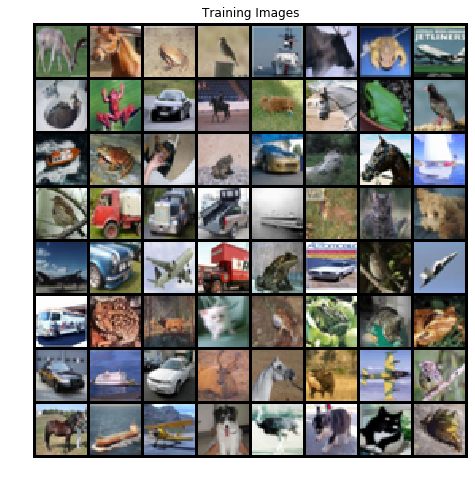

In [12]:
device = torch.device("cuda:0" if torch.cuda else "cpu")
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (ma

In [15]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr,betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr,betas=(0.5,0.999))

In [16]:
img_list = []
G_losses = []
D_losses = []
iters = 0
outf = "Output_GAN"
print("Starting Training Loop...")
import torch.nn.functional as F
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainLoader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        real_cpu= F.upsample(real_cpu, size=(64,64), mode="bilinear")
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainLoader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if i%50==0:
            fake =netG(fixed_noise)
            vutils.save_image(fake.detach(),
                        '%s/fake_samples_epoch_%04d.png' % (outf, epoch),
                        normalize=True)
        

        iters += 1

Starting Training Loop...
[0/20][0/782]	Loss_D: 1.7902	Loss_G: 1.5482	D(x): 0.5375	D(G(z)): 0.5830 / 0.2588


/home/mohit1_aml/anaconda3/envs/mohitpy36/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/mohit1_aml/anaconda3/envs/mohitpy36/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0/20][50/782]	Loss_D: 0.0988	Loss_G: 5.0896	D(x): 0.9716	D(G(z)): 0.0628 / 0.0089
[0/20][100/782]	Loss_D: 0.0377	Loss_G: 6.8317	D(x): 0.9940	D(G(z)): 0.0305 / 0.0015
[0/20][150/782]	Loss_D: 0.0901	Loss_G: 8.8068	D(x): 0.9860	D(G(z)): 0.0710 / 0.0002
[0/20][200/782]	Loss_D: 0.0144	Loss_G: 13.5507	D(x): 0.9864	D(G(z)): 0.0000 / 0.0000
[0/20][250/782]	Loss_D: 0.0027	Loss_G: 9.8814	D(x): 0.9990	D(G(z)): 0.0017 / 0.0001
[0/20][300/782]	Loss_D: 0.0148	Loss_G: 6.6020	D(x): 0.9935	D(G(z)): 0.0081 / 0.0016
[0/20][350/782]	Loss_D: 0.0119	Loss_G: 6.6585	D(x): 0.9930	D(G(z)): 0.0045 / 0.0014
[0/20][400/782]	Loss_D: 0.0060	Loss_G: 6.6797	D(x): 0.9975	D(G(z)): 0.0034 / 0.0014
[0/20][450/782]	Loss_D: 0.0057	Loss_G: 6.6463	D(x): 0.9997	D(G(z)): 0.0054 / 0.0015
[0/20][500/782]	Loss_D: 0.0056	Loss_G: 7.0441	D(x): 0.9994	D(G(z)): 0.0051 / 0.0010
[0/20][550/782]	Loss_D: 0.0100	Loss_G: 7.7727	D(x): 0.9970	D(G(z)): 0.0069 / 0.0005
[0/20][600/782]	Loss_D: 0.0058	Loss_G: 7.8514	D(x): 0.9997	D(G(z)): 0.0055 /

[6/20][150/782]	Loss_D: 0.0001	Loss_G: 9.9763	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[6/20][200/782]	Loss_D: 0.0001	Loss_G: 10.3218	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][250/782]	Loss_D: 0.0000	Loss_G: 10.4572	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][300/782]	Loss_D: 0.0000	Loss_G: 10.5486	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][350/782]	Loss_D: 0.0000	Loss_G: 10.6352	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][400/782]	Loss_D: 0.0009	Loss_G: 9.8969	D(x): 0.9991	D(G(z)): 0.0000 / 0.0001
[6/20][450/782]	Loss_D: 0.0000	Loss_G: 10.8127	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][500/782]	Loss_D: 0.0003	Loss_G: 10.7112	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[6/20][550/782]	Loss_D: 0.0000	Loss_G: 10.6069	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][600/782]	Loss_D: 0.0000	Loss_G: 10.4363	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][650/782]	Loss_D: 0.0000	Loss_G: 10.5800	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/20][700/782]	Loss_D: 0.0000	Loss_G: 10.2822	D(x): 1.0000	D(G(z))

[12/20][200/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][250/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][300/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][350/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][400/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][450/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][500/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][550/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][600/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][650/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][700/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[12/20][750/782]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 

KeyboardInterrupt: 

In [ ]:
niter=30
outf = "GAN_OUT"
import torch.nn.functional as F
for epoch in range(niter):
    for i, data in enumerate(trainLoader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        real_cpu = F.upsample(real_cpu, size=(64,64), mode="bilinear")
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(trainLoader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)


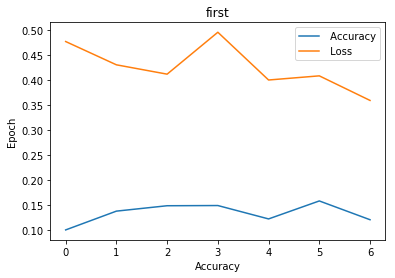

In [22]:
import matplotlib.pyplot as plt
def plot_graph(train_acc,testacc,subject):
    ep = [ i for i in range(len(train_acc))]
    plt.clf()
    plt.plot(ep,train_acc,label=' Accuracy')
    plt.plot(ep,testacc,label=' Loss')
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.title(subject)
    plt.legend()
    plt.savefig(subject+".png")
    
# train_acc=[0.33476, 0.3678, 0.39984, 0.41262, 0.46552, 0.5129, 0.53754,
# 0.57736, 0.56404, 0.65226]
# train_acc=[0.77912, 0.80252, 0.81018, 0.8151, 0.82008,0.8343,0.844,0.8544,0.8345,0.865]
# # # train_acc= [0.94052, 0.95156, 0.95186, 0.9427, 0.95264, 0.9529, 0.95986,
# # # 0.95256, 0.9593, 0.95164]
# # train_acc = [0.87654,0.90328,0.9194,0.9265,0.9389,0.9453,0.9345,0.954,0.944,0.9526]
# # test_acc = [ 0.89012,0.91012,0.9202, 0.9263,0.9319,0.921,0.9343,0.9234,0.923,0.9345]


# train_acc=[i+0.0345 for i in train_acc]
# # test_acc =[0.3315, 0.3649, 0.3984, 0.4035, 0.4502, 0.4945, 0.5204, 0.546,
# # 0.5446, 0.6129]
# test_acc=[0.7764, 0.794, 0.7988, 0.7997, 0.8051,0.8020,0.823,0.827,0.836,0.839]
# # test_acc=[0.921, 0.9305, 0.9293, 0.9119, 0.9218, 0.9187, 0.9287, 0.9224,
# # 0.9263, 0.9154]
# test_acc =[i-0.0 for i in test_acc]
acc=[0.1004,0.138,0.1488,0.1492,0.1224,0.1584,0.1208]
loss=[0.4775,0.4309,0.4122,0.4961,0.4005,0.4088,0.3596]
plot_graph(acc,loss,"first")



In [ ]:
# 
# [0.7764, 0.794, 0.7988, 0.7997, 0.8051]